In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 23:56:49.190292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 23:56:49.190321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-07 23:56:53.071296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 23:56:53.071336: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 23:56:53.071361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 23:56:53.071639: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 2s 21ms/step - loss: 0.7097 - accuracy: 0.5111 - auc: 0.5254 - val_loss: 0.6906 - val_accuracy: 0.5225 - val_auc: 0.5616
Epoch 2/394
39/39 [==============================] - 0s 7ms/step - loss: 0.7049 - accuracy: 0.5160 - auc: 0.5302 - val_loss: 0.6887 - val_accuracy: 0.5340 - val_auc: 0.5649
Epoch 3/394
39/39 [==============================] - 0s 7ms/step - loss: 0.7037 - accuracy: 0.5183 - auc: 0.5230 - val_loss: 0.6874 - val_accuracy: 0.5434 - val_auc: 0.5684
Epoch 4/394
39/39 [==============================] - 0s 9ms/step - loss: 0.7004 - accuracy: 0.5115 - auc: 0.5250 - val_loss: 0.6866 - val_accuracy: 0.5493 - val_auc: 0.5716
Epoch 5/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6998 - accuracy: 0.5087 - auc: 0.5272 - val_loss: 0.6860 - val_accuracy: 0.5567 - val_auc: 0.5758
Epoch 6/394
39/39 [==============================] - 0s 13ms/step - loss: 0.6980 - accuracy: 0.5248 - auc: 0.5328 - val_loss: 0.6855 - val_accurac

39/39 [==============================] - 0s 12ms/step - loss: 0.6648 - accuracy: 0.5984 - auc: 0.6359 - val_loss: 0.6464 - val_accuracy: 0.6763 - val_auc: 0.7437
Epoch 49/394
39/39 [==============================] - 0s 13ms/step - loss: 0.6618 - accuracy: 0.6088 - auc: 0.6457 - val_loss: 0.6449 - val_accuracy: 0.6787 - val_auc: 0.7459
Epoch 50/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6605 - accuracy: 0.6066 - auc: 0.6487 - val_loss: 0.6434 - val_accuracy: 0.6823 - val_auc: 0.7486
Epoch 51/394
39/39 [==============================] - 0s 6ms/step - loss: 0.6587 - accuracy: 0.6049 - auc: 0.6497 - val_loss: 0.6418 - val_accuracy: 0.6840 - val_auc: 0.7509
Epoch 52/394
39/39 [==============================] - 1s 23ms/step - loss: 0.6596 - accuracy: 0.6027 - auc: 0.6469 - val_loss: 0.6404 - val_accuracy: 0.6865 - val_auc: 0.7530
Epoch 53/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6562 - accuracy: 0.6146 - auc: 0.6584 - val_loss: 0.6389 - val_a

39/39 [==============================] - 0s 8ms/step - loss: 0.6052 - accuracy: 0.6808 - auc: 0.7411 - val_loss: 0.5696 - val_accuracy: 0.7440 - val_auc: 0.8196
Epoch 96/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6018 - accuracy: 0.6782 - auc: 0.7436 - val_loss: 0.5680 - val_accuracy: 0.7455 - val_auc: 0.8205
Epoch 97/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6010 - accuracy: 0.6766 - auc: 0.7441 - val_loss: 0.5664 - val_accuracy: 0.7465 - val_auc: 0.8215
Epoch 98/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6043 - accuracy: 0.6768 - auc: 0.7404 - val_loss: 0.5651 - val_accuracy: 0.7480 - val_auc: 0.8224
Epoch 99/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5987 - accuracy: 0.6790 - auc: 0.7481 - val_loss: 0.5637 - val_accuracy: 0.7492 - val_auc: 0.8233
Epoch 100/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6028 - accuracy: 0.6823 - auc: 0.7436 - val_loss: 0.5625 - val_acc

Epoch 142/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5638 - accuracy: 0.7181 - auc: 0.7887 - val_loss: 0.5158 - val_accuracy: 0.7843 - val_auc: 0.8523
Epoch 143/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5598 - accuracy: 0.7263 - auc: 0.7926 - val_loss: 0.5150 - val_accuracy: 0.7851 - val_auc: 0.8528
Epoch 144/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5574 - accuracy: 0.7273 - auc: 0.7954 - val_loss: 0.5141 - val_accuracy: 0.7863 - val_auc: 0.8533
Epoch 145/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5574 - accuracy: 0.7240 - auc: 0.7942 - val_loss: 0.5134 - val_accuracy: 0.7868 - val_auc: 0.8537
Epoch 146/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5595 - accuracy: 0.7188 - auc: 0.7923 - val_loss: 0.5127 - val_accuracy: 0.7879 - val_auc: 0.8541
Epoch 147/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5549 - accuracy: 0.7286 - auc: 0.7984 - val_loss

Epoch 189/394
39/39 [==============================] - 0s 13ms/step - loss: 0.5397 - accuracy: 0.7499 - auc: 0.8151 - val_loss: 0.4897 - val_accuracy: 0.8097 - val_auc: 0.8662
Epoch 190/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5351 - accuracy: 0.7480 - auc: 0.8166 - val_loss: 0.4893 - val_accuracy: 0.8094 - val_auc: 0.8664
Epoch 191/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5342 - accuracy: 0.7503 - auc: 0.8188 - val_loss: 0.4889 - val_accuracy: 0.8102 - val_auc: 0.8665
Epoch 192/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5382 - accuracy: 0.7541 - auc: 0.8176 - val_loss: 0.4886 - val_accuracy: 0.8106 - val_auc: 0.8667
Epoch 193/394
39/39 [==============================] - 1s 14ms/step - loss: 0.5394 - accuracy: 0.7437 - auc: 0.8153 - val_loss: 0.4884 - val_accuracy: 0.8105 - val_auc: 0.8670
Epoch 194/394
39/39 [==============================] - 1s 13ms/step - loss: 0.5340 - accuracy: 0.7495 - auc: 0.8192 - val_

Epoch 236/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5205 - accuracy: 0.7657 - auc: 0.8324 - val_loss: 0.4763 - val_accuracy: 0.8227 - val_auc: 0.8723
Epoch 237/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5202 - accuracy: 0.7661 - auc: 0.8334 - val_loss: 0.4761 - val_accuracy: 0.8227 - val_auc: 0.8724
Epoch 238/394
39/39 [==============================] - 0s 13ms/step - loss: 0.5199 - accuracy: 0.7632 - auc: 0.8304 - val_loss: 0.4759 - val_accuracy: 0.8229 - val_auc: 0.8725
Epoch 239/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5214 - accuracy: 0.7629 - auc: 0.8308 - val_loss: 0.4757 - val_accuracy: 0.8231 - val_auc: 0.8726
Epoch 240/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5220 - accuracy: 0.7622 - auc: 0.8313 - val_loss: 0.4755 - val_accuracy: 0.8235 - val_auc: 0.8727
Epoch 241/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5226 - accuracy: 0.7587 - auc: 0.8290 - val_lo

Epoch 283/394
39/39 [==============================] - 0s 11ms/step - loss: 0.5135 - accuracy: 0.7739 - auc: 0.8384 - val_loss: 0.4670 - val_accuracy: 0.8292 - val_auc: 0.8762
Epoch 284/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5087 - accuracy: 0.7735 - auc: 0.8407 - val_loss: 0.4669 - val_accuracy: 0.8289 - val_auc: 0.8763
Epoch 285/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5078 - accuracy: 0.7775 - auc: 0.8420 - val_loss: 0.4667 - val_accuracy: 0.8294 - val_auc: 0.8764
Epoch 286/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5077 - accuracy: 0.7706 - auc: 0.8401 - val_loss: 0.4666 - val_accuracy: 0.8291 - val_auc: 0.8765
Epoch 287/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5088 - accuracy: 0.7724 - auc: 0.8398 - val_loss: 0.4664 - val_accuracy: 0.8293 - val_auc: 0.8765
Epoch 288/394
39/39 [==============================] - 1s 13ms/step - loss: 0.5054 - accuracy: 0.7778 - auc: 0.8441 - val_l

Epoch 330/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4999 - accuracy: 0.7834 - auc: 0.8484 - val_loss: 0.4590 - val_accuracy: 0.8346 - val_auc: 0.8798
Epoch 331/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4981 - accuracy: 0.7885 - auc: 0.8509 - val_loss: 0.4588 - val_accuracy: 0.8346 - val_auc: 0.8798
Epoch 332/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4952 - accuracy: 0.7877 - auc: 0.8509 - val_loss: 0.4586 - val_accuracy: 0.8346 - val_auc: 0.8799
Epoch 333/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4940 - accuracy: 0.7861 - auc: 0.8514 - val_loss: 0.4583 - val_accuracy: 0.8350 - val_auc: 0.8800
Epoch 334/394
39/39 [==============================] - 0s 11ms/step - loss: 0.4945 - accuracy: 0.7789 - auc: 0.8494 - val_loss: 0.4581 - val_accuracy: 0.8349 - val_auc: 0.8801
Epoch 335/394
39/39 [==============================] - 0s 13ms/step - loss: 0.5019 - accuracy: 0.7819 - auc: 0.8470 - val_lo

Epoch 377/394
39/39 [==============================] - 1s 13ms/step - loss: 0.4929 - accuracy: 0.7866 - auc: 0.8530 - val_loss: 0.4509 - val_accuracy: 0.8365 - val_auc: 0.8833
Epoch 378/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4837 - accuracy: 0.7887 - auc: 0.8571 - val_loss: 0.4508 - val_accuracy: 0.8366 - val_auc: 0.8834
Epoch 379/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4834 - accuracy: 0.7906 - auc: 0.8581 - val_loss: 0.4506 - val_accuracy: 0.8363 - val_auc: 0.8835
Epoch 380/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4889 - accuracy: 0.7900 - auc: 0.8548 - val_loss: 0.4503 - val_accuracy: 0.8368 - val_auc: 0.8836
Epoch 381/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4886 - accuracy: 0.7944 - auc: 0.8559 - val_loss: 0.4501 - val_accuracy: 0.8369 - val_auc: 0.8837
Epoch 382/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4850 - accuracy: 0.7915 - auc: 0.8571 - val_los

39/39 [==============================] - 0s 8ms/step - loss: 0.6608 - accuracy: 0.6098 - auc: 0.6580 - val_loss: 0.6484 - val_accuracy: 0.6985 - val_auc: 0.7623
Epoch 29/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6602 - accuracy: 0.6125 - auc: 0.6591 - val_loss: 0.6462 - val_accuracy: 0.7017 - val_auc: 0.7659
Epoch 30/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6579 - accuracy: 0.6156 - auc: 0.6625 - val_loss: 0.6439 - val_accuracy: 0.7037 - val_auc: 0.7698
Epoch 31/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6589 - accuracy: 0.6158 - auc: 0.6614 - val_loss: 0.6415 - val_accuracy: 0.7075 - val_auc: 0.7734
Epoch 32/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6564 - accuracy: 0.6168 - auc: 0.6655 - val_loss: 0.6392 - val_accuracy: 0.7110 - val_auc: 0.7769
Epoch 33/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6524 - accuracy: 0.6220 - auc: 0.6763 - val_loss: 0.6367 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.5765 - accuracy: 0.7135 - auc: 0.7783 - val_loss: 0.5307 - val_accuracy: 0.7930 - val_auc: 0.8535
Epoch 76/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5710 - accuracy: 0.7096 - auc: 0.7812 - val_loss: 0.5289 - val_accuracy: 0.7939 - val_auc: 0.8541
Epoch 77/394
39/39 [==============================] - 0s 10ms/step - loss: 0.5740 - accuracy: 0.7058 - auc: 0.7789 - val_loss: 0.5273 - val_accuracy: 0.7950 - val_auc: 0.8546
Epoch 78/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5693 - accuracy: 0.7119 - auc: 0.7840 - val_loss: 0.5256 - val_accuracy: 0.7964 - val_auc: 0.8553
Epoch 79/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5759 - accuracy: 0.7088 - auc: 0.7779 - val_loss: 0.5240 - val_accuracy: 0.7969 - val_auc: 0.8558
Epoch 80/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5709 - accuracy: 0.7100 - auc: 0.7810 - val_loss: 0.5226 - val_ac

Epoch 122/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5324 - accuracy: 0.7490 - auc: 0.8212 - val_loss: 0.4855 - val_accuracy: 0.8191 - val_auc: 0.8687
Epoch 123/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5413 - accuracy: 0.7466 - auc: 0.8136 - val_loss: 0.4851 - val_accuracy: 0.8192 - val_auc: 0.8689
Epoch 124/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5306 - accuracy: 0.7476 - auc: 0.8195 - val_loss: 0.4846 - val_accuracy: 0.8198 - val_auc: 0.8691
Epoch 125/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5310 - accuracy: 0.7520 - auc: 0.8223 - val_loss: 0.4840 - val_accuracy: 0.8203 - val_auc: 0.8693
Epoch 126/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5344 - accuracy: 0.7496 - auc: 0.8197 - val_loss: 0.4836 - val_accuracy: 0.8206 - val_auc: 0.8694
Epoch 127/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5349 - accuracy: 0.7422 - auc: 0.8171 - val_los

Epoch 169/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5138 - accuracy: 0.7713 - auc: 0.8378 - val_loss: 0.4680 - val_accuracy: 0.8291 - val_auc: 0.8749
Epoch 170/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5100 - accuracy: 0.7736 - auc: 0.8404 - val_loss: 0.4676 - val_accuracy: 0.8294 - val_auc: 0.8751
Epoch 171/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5140 - accuracy: 0.7722 - auc: 0.8373 - val_loss: 0.4673 - val_accuracy: 0.8296 - val_auc: 0.8752
Epoch 172/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5144 - accuracy: 0.7707 - auc: 0.8372 - val_loss: 0.4670 - val_accuracy: 0.8298 - val_auc: 0.8753
Epoch 173/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5171 - accuracy: 0.7759 - auc: 0.8372 - val_loss: 0.4667 - val_accuracy: 0.8305 - val_auc: 0.8754
Epoch 174/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5142 - accuracy: 0.7696 - auc: 0.8372 - val_los

Epoch 216/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4961 - accuracy: 0.7870 - auc: 0.8507 - val_loss: 0.4557 - val_accuracy: 0.8369 - val_auc: 0.8797
Epoch 217/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4982 - accuracy: 0.7831 - auc: 0.8477 - val_loss: 0.4555 - val_accuracy: 0.8367 - val_auc: 0.8798
Epoch 218/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4953 - accuracy: 0.7865 - auc: 0.8506 - val_loss: 0.4552 - val_accuracy: 0.8367 - val_auc: 0.8799
Epoch 219/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4960 - accuracy: 0.7909 - auc: 0.8525 - val_loss: 0.4549 - val_accuracy: 0.8368 - val_auc: 0.8800
Epoch 220/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4956 - accuracy: 0.7886 - auc: 0.8532 - val_loss: 0.4547 - val_accuracy: 0.8368 - val_auc: 0.8801
Epoch 221/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4943 - accuracy: 0.7866 - auc: 0.8510 - val_lo

Epoch 263/394
39/39 [==============================] - 0s 11ms/step - loss: 0.4795 - accuracy: 0.7958 - auc: 0.8606 - val_loss: 0.4442 - val_accuracy: 0.8410 - val_auc: 0.8843
Epoch 264/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4816 - accuracy: 0.7923 - auc: 0.8612 - val_loss: 0.4440 - val_accuracy: 0.8411 - val_auc: 0.8844
Epoch 265/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4844 - accuracy: 0.7934 - auc: 0.8575 - val_loss: 0.4437 - val_accuracy: 0.8411 - val_auc: 0.8845
Epoch 266/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4839 - accuracy: 0.7949 - auc: 0.8587 - val_loss: 0.4435 - val_accuracy: 0.8411 - val_auc: 0.8846
Epoch 267/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4803 - accuracy: 0.7961 - auc: 0.8611 - val_loss: 0.4433 - val_accuracy: 0.8411 - val_auc: 0.8847
Epoch 268/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4814 - accuracy: 0.7959 - auc: 0.8597 - val_los

Epoch 310/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4678 - accuracy: 0.8049 - auc: 0.8679 - val_loss: 0.4333 - val_accuracy: 0.8440 - val_auc: 0.8889
Epoch 311/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4688 - accuracy: 0.8101 - auc: 0.8685 - val_loss: 0.4331 - val_accuracy: 0.8444 - val_auc: 0.8891
Epoch 312/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4697 - accuracy: 0.8038 - auc: 0.8676 - val_loss: 0.4329 - val_accuracy: 0.8441 - val_auc: 0.8892
Epoch 313/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4676 - accuracy: 0.8071 - auc: 0.8690 - val_loss: 0.4327 - val_accuracy: 0.8442 - val_auc: 0.8893
Epoch 314/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4710 - accuracy: 0.8045 - auc: 0.8672 - val_loss: 0.4324 - val_accuracy: 0.8445 - val_auc: 0.8894
Epoch 315/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4647 - accuracy: 0.8091 - auc: 0.8708 - val_loss

Epoch 357/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4551 - accuracy: 0.8122 - auc: 0.8757 - val_loss: 0.4229 - val_accuracy: 0.8450 - val_auc: 0.8939
Epoch 358/394
39/39 [==============================] - 1s 14ms/step - loss: 0.4599 - accuracy: 0.8082 - auc: 0.8733 - val_loss: 0.4228 - val_accuracy: 0.8453 - val_auc: 0.8939
Epoch 359/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4590 - accuracy: 0.8122 - auc: 0.8737 - val_loss: 0.4225 - val_accuracy: 0.8450 - val_auc: 0.8941
Epoch 360/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4547 - accuracy: 0.8143 - auc: 0.8758 - val_loss: 0.4223 - val_accuracy: 0.8451 - val_auc: 0.8942
Epoch 361/394
39/39 [==============================] - 1s 15ms/step - loss: 0.4576 - accuracy: 0.8143 - auc: 0.8746 - val_loss: 0.4221 - val_accuracy: 0.8455 - val_auc: 0.8943
Epoch 362/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4571 - accuracy: 0.8100 - auc: 0.8742 - val_lo

39/39 [==============================] - 0s 12ms/step - loss: 0.6828 - accuracy: 0.5576 - auc: 0.5784 - val_loss: 0.6734 - val_accuracy: 0.6043 - val_auc: 0.6522
Epoch 9/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6823 - accuracy: 0.5588 - auc: 0.5795 - val_loss: 0.6712 - val_accuracy: 0.6134 - val_auc: 0.6623
Epoch 10/394
39/39 [==============================] - 0s 6ms/step - loss: 0.6804 - accuracy: 0.5615 - auc: 0.5864 - val_loss: 0.6691 - val_accuracy: 0.6194 - val_auc: 0.6700
Epoch 11/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6785 - accuracy: 0.5620 - auc: 0.5919 - val_loss: 0.6669 - val_accuracy: 0.6266 - val_auc: 0.6786
Epoch 12/394
39/39 [==============================] - 0s 6ms/step - loss: 0.6778 - accuracy: 0.5651 - auc: 0.5926 - val_loss: 0.6648 - val_accuracy: 0.6331 - val_auc: 0.6864
Epoch 13/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6736 - accuracy: 0.5772 - auc: 0.6110 - val_loss: 0.6626 - val_accu

39/39 [==============================] - 0s 9ms/step - loss: 0.5838 - accuracy: 0.6915 - auc: 0.7641 - val_loss: 0.5394 - val_accuracy: 0.7800 - val_auc: 0.8465
Epoch 56/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5795 - accuracy: 0.6989 - auc: 0.7710 - val_loss: 0.5370 - val_accuracy: 0.7812 - val_auc: 0.8476
Epoch 57/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5843 - accuracy: 0.7011 - auc: 0.7659 - val_loss: 0.5351 - val_accuracy: 0.7839 - val_auc: 0.8486
Epoch 58/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5803 - accuracy: 0.7000 - auc: 0.7703 - val_loss: 0.5330 - val_accuracy: 0.7851 - val_auc: 0.8495
Epoch 59/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5814 - accuracy: 0.7008 - auc: 0.7692 - val_loss: 0.5312 - val_accuracy: 0.7855 - val_auc: 0.8505
Epoch 60/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5761 - accuracy: 0.7066 - auc: 0.7774 - val_loss: 0.5293 - val_acc

39/39 [==============================] - 0s 8ms/step - loss: 0.5437 - accuracy: 0.7432 - auc: 0.8105 - val_loss: 0.4875 - val_accuracy: 0.8154 - val_auc: 0.8681
Epoch 103/394
39/39 [==============================] - 0s 11ms/step - loss: 0.5378 - accuracy: 0.7475 - auc: 0.8167 - val_loss: 0.4870 - val_accuracy: 0.8158 - val_auc: 0.8683
Epoch 104/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5312 - accuracy: 0.7524 - auc: 0.8220 - val_loss: 0.4864 - val_accuracy: 0.8159 - val_auc: 0.8685
Epoch 105/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5336 - accuracy: 0.7506 - auc: 0.8195 - val_loss: 0.4859 - val_accuracy: 0.8164 - val_auc: 0.8687
Epoch 106/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5353 - accuracy: 0.7527 - auc: 0.8196 - val_loss: 0.4854 - val_accuracy: 0.8162 - val_auc: 0.8689
Epoch 107/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5372 - accuracy: 0.7477 - auc: 0.8157 - val_loss: 0.4850 - va

Epoch 149/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5155 - accuracy: 0.7633 - auc: 0.8361 - val_loss: 0.4706 - val_accuracy: 0.8269 - val_auc: 0.8746
Epoch 150/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5112 - accuracy: 0.7737 - auc: 0.8407 - val_loss: 0.4702 - val_accuracy: 0.8267 - val_auc: 0.8747
Epoch 151/394
39/39 [==============================] - 0s 10ms/step - loss: 0.5166 - accuracy: 0.7702 - auc: 0.8347 - val_loss: 0.4699 - val_accuracy: 0.8271 - val_auc: 0.8748
Epoch 152/394
39/39 [==============================] - 1s 13ms/step - loss: 0.5167 - accuracy: 0.7713 - auc: 0.8363 - val_loss: 0.4697 - val_accuracy: 0.8268 - val_auc: 0.8749
Epoch 153/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5246 - accuracy: 0.7632 - auc: 0.8297 - val_loss: 0.4695 - val_accuracy: 0.8267 - val_auc: 0.8751
Epoch 154/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5147 - accuracy: 0.7723 - auc: 0.8379 - val_lo

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5036 - accuracy: 0.7843 - auc: 0.8465 - val_loss: 0.4585 - val_accuracy: 0.8328 - val_auc: 0.8798
Epoch 197/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4976 - accuracy: 0.7854 - auc: 0.8484 - val_loss: 0.4582 - val_accuracy: 0.8332 - val_auc: 0.8799
Epoch 198/394
39/39 [==============================] - 0s 13ms/step - loss: 0.4985 - accuracy: 0.7797 - auc: 0.8477 - val_loss: 0.4579 - val_accuracy: 0.8332 - val_auc: 0.8800
Epoch 199/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4995 - accuracy: 0.7852 - auc: 0.8494 - val_loss: 0.4577 - val_accuracy: 0.8334 - val_auc: 0.8801
Epoch 200/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5005 - accuracy: 0.7816 - auc: 0.8466 - val_loss: 0.4574 - val_accuracy: 0.8335 - val_auc: 0.8802
Epoch 201/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5027 - accuracy: 0.7806 - auc: 0.8452 - val_l

Epoch 243/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4903 - accuracy: 0.7912 - auc: 0.8551 - val_loss: 0.4468 - val_accuracy: 0.8377 - val_auc: 0.8852
Epoch 244/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4906 - accuracy: 0.7900 - auc: 0.8548 - val_loss: 0.4466 - val_accuracy: 0.8377 - val_auc: 0.8853
Epoch 245/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4858 - accuracy: 0.7881 - auc: 0.8554 - val_loss: 0.4463 - val_accuracy: 0.8381 - val_auc: 0.8855
Epoch 246/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4855 - accuracy: 0.7948 - auc: 0.8579 - val_loss: 0.4460 - val_accuracy: 0.8378 - val_auc: 0.8855
Epoch 247/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4841 - accuracy: 0.7951 - auc: 0.8579 - val_loss: 0.4457 - val_accuracy: 0.8385 - val_auc: 0.8855
Epoch 248/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4846 - accuracy: 0.7913 - auc: 0.8575 - val_loss

Epoch 290/394
39/39 [==============================] - 0s 13ms/step - loss: 0.4742 - accuracy: 0.8001 - auc: 0.8646 - val_loss: 0.4344 - val_accuracy: 0.8421 - val_auc: 0.8912
Epoch 291/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4694 - accuracy: 0.8065 - auc: 0.8677 - val_loss: 0.4341 - val_accuracy: 0.8421 - val_auc: 0.8913
Epoch 292/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4688 - accuracy: 0.8029 - auc: 0.8671 - val_loss: 0.4340 - val_accuracy: 0.8423 - val_auc: 0.8914
Epoch 293/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4752 - accuracy: 0.8043 - auc: 0.8654 - val_loss: 0.4338 - val_accuracy: 0.8426 - val_auc: 0.8915
Epoch 294/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4770 - accuracy: 0.7998 - auc: 0.8633 - val_loss: 0.4337 - val_accuracy: 0.8426 - val_auc: 0.8916
Epoch 295/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4674 - accuracy: 0.8058 - auc: 0.8682 - val_l

Epoch 337/394
39/39 [==============================] - 1s 13ms/step - loss: 0.4636 - accuracy: 0.8049 - auc: 0.8708 - val_loss: 0.4228 - val_accuracy: 0.8453 - val_auc: 0.8971
Epoch 338/394
39/39 [==============================] - 1s 14ms/step - loss: 0.4614 - accuracy: 0.8051 - auc: 0.8716 - val_loss: 0.4225 - val_accuracy: 0.8454 - val_auc: 0.8972
Epoch 339/394
39/39 [==============================] - 1s 13ms/step - loss: 0.4606 - accuracy: 0.8088 - auc: 0.8722 - val_loss: 0.4223 - val_accuracy: 0.8452 - val_auc: 0.8974
Epoch 340/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4540 - accuracy: 0.8113 - auc: 0.8766 - val_loss: 0.4220 - val_accuracy: 0.8452 - val_auc: 0.8975
Epoch 341/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4605 - accuracy: 0.8049 - auc: 0.8728 - val_loss: 0.4218 - val_accuracy: 0.8451 - val_auc: 0.8976
Epoch 342/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4612 - accuracy: 0.8051 - auc: 0.8707 - val_

Epoch 384/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4473 - accuracy: 0.8157 - auc: 0.8795 - val_loss: 0.4124 - val_accuracy: 0.8481 - val_auc: 0.9021
Epoch 385/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4458 - accuracy: 0.8149 - auc: 0.8818 - val_loss: 0.4122 - val_accuracy: 0.8481 - val_auc: 0.9021
Epoch 386/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4423 - accuracy: 0.8142 - auc: 0.8835 - val_loss: 0.4120 - val_accuracy: 0.8483 - val_auc: 0.9022
Epoch 387/394
39/39 [==============================] - 0s 13ms/step - loss: 0.4460 - accuracy: 0.8118 - auc: 0.8803 - val_loss: 0.4117 - val_accuracy: 0.8482 - val_auc: 0.9023
Epoch 388/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4452 - accuracy: 0.8168 - auc: 0.8811 - val_loss: 0.4115 - val_accuracy: 0.8480 - val_auc: 0.9024
Epoch 389/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4448 - accuracy: 0.8131 - auc: 0.8811 - val_lo

39/39 [==============================] - 0s 8ms/step - loss: 0.6955 - accuracy: 0.5160 - auc: 0.5209 - val_loss: 0.6880 - val_accuracy: 0.5379 - val_auc: 0.5888
Epoch 36/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6959 - accuracy: 0.5147 - auc: 0.5203 - val_loss: 0.6878 - val_accuracy: 0.5403 - val_auc: 0.5915
Epoch 37/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6954 - accuracy: 0.5160 - auc: 0.5219 - val_loss: 0.6875 - val_accuracy: 0.5424 - val_auc: 0.5940
Epoch 38/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6936 - accuracy: 0.5171 - auc: 0.5292 - val_loss: 0.6872 - val_accuracy: 0.5436 - val_auc: 0.5967
Epoch 39/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5240 - auc: 0.5322 - val_loss: 0.6870 - val_accuracy: 0.5457 - val_auc: 0.5993
Epoch 40/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.5241 - auc: 0.5391 - val_loss: 0.6868 - val_ac

39/39 [==============================] - 0s 7ms/step - loss: 0.6850 - accuracy: 0.5515 - auc: 0.5713 - val_loss: 0.6764 - val_accuracy: 0.6075 - val_auc: 0.6771
Epoch 83/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6845 - accuracy: 0.5488 - auc: 0.5705 - val_loss: 0.6761 - val_accuracy: 0.6083 - val_auc: 0.6783
Epoch 84/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6839 - accuracy: 0.5519 - auc: 0.5756 - val_loss: 0.6758 - val_accuracy: 0.6103 - val_auc: 0.6796
Epoch 85/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6821 - accuracy: 0.5541 - auc: 0.5822 - val_loss: 0.6755 - val_accuracy: 0.6109 - val_auc: 0.6807
Epoch 86/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6837 - accuracy: 0.5542 - auc: 0.5784 - val_loss: 0.6752 - val_accuracy: 0.6122 - val_auc: 0.6823
Epoch 87/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6818 - accuracy: 0.5559 - auc: 0.5849 - val_loss: 0.6749 - val_accu

Epoch 129/828
39/39 [==============================] - 1s 16ms/step - loss: 0.6703 - accuracy: 0.5838 - auc: 0.6221 - val_loss: 0.6571 - val_accuracy: 0.6729 - val_auc: 0.7392
Epoch 130/828
39/39 [==============================] - 0s 13ms/step - loss: 0.6676 - accuracy: 0.5898 - auc: 0.6328 - val_loss: 0.6565 - val_accuracy: 0.6752 - val_auc: 0.7406
Epoch 131/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6675 - accuracy: 0.5919 - auc: 0.6340 - val_loss: 0.6559 - val_accuracy: 0.6759 - val_auc: 0.7421
Epoch 132/828
39/39 [==============================] - 0s 13ms/step - loss: 0.6688 - accuracy: 0.5923 - auc: 0.6262 - val_loss: 0.6554 - val_accuracy: 0.6765 - val_auc: 0.7437
Epoch 133/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6656 - accuracy: 0.5971 - auc: 0.6391 - val_loss: 0.6548 - val_accuracy: 0.6777 - val_auc: 0.7451
Epoch 134/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6682 - accuracy: 0.5911 - auc: 0.6295 - val_l

Epoch 176/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6407 - accuracy: 0.6288 - auc: 0.6891 - val_loss: 0.6200 - val_accuracy: 0.7292 - val_auc: 0.7966
Epoch 177/828
39/39 [==============================] - 1s 14ms/step - loss: 0.6418 - accuracy: 0.6353 - auc: 0.6875 - val_loss: 0.6189 - val_accuracy: 0.7308 - val_auc: 0.7978
Epoch 178/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6439 - accuracy: 0.6284 - auc: 0.6816 - val_loss: 0.6179 - val_accuracy: 0.7319 - val_auc: 0.7989
Epoch 179/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6403 - accuracy: 0.6386 - auc: 0.6930 - val_loss: 0.6169 - val_accuracy: 0.7326 - val_auc: 0.8000
Epoch 180/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6393 - accuracy: 0.6344 - auc: 0.6897 - val_loss: 0.6158 - val_accuracy: 0.7333 - val_auc: 0.8011
Epoch 181/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6400 - accuracy: 0.6366 - auc: 0.6915 - val_lo

Epoch 223/828
39/39 [==============================] - 0s 10ms/step - loss: 0.6042 - accuracy: 0.6865 - auc: 0.7450 - val_loss: 0.5643 - val_accuracy: 0.7729 - val_auc: 0.8400
Epoch 224/828
39/39 [==============================] - 0s 10ms/step - loss: 0.6046 - accuracy: 0.6726 - auc: 0.7403 - val_loss: 0.5632 - val_accuracy: 0.7743 - val_auc: 0.8406
Epoch 225/828
39/39 [==============================] - 1s 13ms/step - loss: 0.6082 - accuracy: 0.6718 - auc: 0.7374 - val_loss: 0.5620 - val_accuracy: 0.7754 - val_auc: 0.8414
Epoch 226/828
39/39 [==============================] - 1s 13ms/step - loss: 0.6024 - accuracy: 0.6817 - auc: 0.7444 - val_loss: 0.5609 - val_accuracy: 0.7764 - val_auc: 0.8419
Epoch 227/828
39/39 [==============================] - 0s 13ms/step - loss: 0.6016 - accuracy: 0.6807 - auc: 0.7467 - val_loss: 0.5597 - val_accuracy: 0.7771 - val_auc: 0.8425
Epoch 228/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6013 - accuracy: 0.6813 - auc: 0.7472 - val

Epoch 270/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5717 - accuracy: 0.7109 - auc: 0.7833 - val_loss: 0.5174 - val_accuracy: 0.8061 - val_auc: 0.8620
Epoch 271/828
39/39 [==============================] - 1s 14ms/step - loss: 0.5706 - accuracy: 0.7109 - auc: 0.7811 - val_loss: 0.5166 - val_accuracy: 0.8067 - val_auc: 0.8622
Epoch 272/828
39/39 [==============================] - 1s 14ms/step - loss: 0.5717 - accuracy: 0.7067 - auc: 0.7801 - val_loss: 0.5160 - val_accuracy: 0.8072 - val_auc: 0.8624
Epoch 273/828
39/39 [==============================] - 1s 14ms/step - loss: 0.5709 - accuracy: 0.7058 - auc: 0.7795 - val_loss: 0.5152 - val_accuracy: 0.8078 - val_auc: 0.8628
Epoch 274/828
39/39 [==============================] - 0s 13ms/step - loss: 0.5736 - accuracy: 0.7094 - auc: 0.7784 - val_loss: 0.5146 - val_accuracy: 0.8079 - val_auc: 0.8631
Epoch 275/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5664 - accuracy: 0.7124 - auc: 0.7858 - val

Epoch 317/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5430 - accuracy: 0.7369 - auc: 0.8097 - val_loss: 0.4914 - val_accuracy: 0.8238 - val_auc: 0.8705
Epoch 318/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5453 - accuracy: 0.7344 - auc: 0.8079 - val_loss: 0.4909 - val_accuracy: 0.8239 - val_auc: 0.8706
Epoch 319/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5430 - accuracy: 0.7412 - auc: 0.8107 - val_loss: 0.4906 - val_accuracy: 0.8242 - val_auc: 0.8707
Epoch 320/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5459 - accuracy: 0.7419 - auc: 0.8107 - val_loss: 0.4902 - val_accuracy: 0.8243 - val_auc: 0.8708
Epoch 321/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5516 - accuracy: 0.7355 - auc: 0.8046 - val_loss: 0.4899 - val_accuracy: 0.8248 - val_auc: 0.8708
Epoch 322/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5451 - accuracy: 0.7368 - auc: 0.8075 - val_lo

Epoch 364/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5321 - accuracy: 0.7521 - auc: 0.8218 - val_loss: 0.4777 - val_accuracy: 0.8317 - val_auc: 0.8742
Epoch 365/828
39/39 [==============================] - 0s 10ms/step - loss: 0.5324 - accuracy: 0.7555 - auc: 0.8230 - val_loss: 0.4775 - val_accuracy: 0.8317 - val_auc: 0.8743
Epoch 366/828
39/39 [==============================] - 1s 13ms/step - loss: 0.5353 - accuracy: 0.7515 - auc: 0.8200 - val_loss: 0.4773 - val_accuracy: 0.8317 - val_auc: 0.8744
Epoch 367/828
39/39 [==============================] - 0s 10ms/step - loss: 0.5319 - accuracy: 0.7542 - auc: 0.8237 - val_loss: 0.4771 - val_accuracy: 0.8317 - val_auc: 0.8744
Epoch 368/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5354 - accuracy: 0.7537 - auc: 0.8215 - val_loss: 0.4769 - val_accuracy: 0.8318 - val_auc: 0.8745
Epoch 369/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5340 - accuracy: 0.7548 - auc: 0.8208 - val_l

Epoch 411/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5192 - accuracy: 0.7675 - auc: 0.8340 - val_loss: 0.4693 - val_accuracy: 0.8347 - val_auc: 0.8766
Epoch 412/828
39/39 [==============================] - 0s 13ms/step - loss: 0.5177 - accuracy: 0.7725 - auc: 0.8343 - val_loss: 0.4691 - val_accuracy: 0.8348 - val_auc: 0.8767
Epoch 413/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5236 - accuracy: 0.7632 - auc: 0.8313 - val_loss: 0.4690 - val_accuracy: 0.8347 - val_auc: 0.8767
Epoch 414/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5245 - accuracy: 0.7637 - auc: 0.8300 - val_loss: 0.4689 - val_accuracy: 0.8351 - val_auc: 0.8767
Epoch 415/828
39/39 [==============================] - 1s 13ms/step - loss: 0.5249 - accuracy: 0.7633 - auc: 0.8290 - val_loss: 0.4688 - val_accuracy: 0.8349 - val_auc: 0.8768
Epoch 416/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5238 - accuracy: 0.7634 - auc: 0.8300 - val_

Epoch 458/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5082 - accuracy: 0.7777 - auc: 0.8420 - val_loss: 0.4625 - val_accuracy: 0.8378 - val_auc: 0.8785
Epoch 459/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5122 - accuracy: 0.7736 - auc: 0.8398 - val_loss: 0.4624 - val_accuracy: 0.8376 - val_auc: 0.8786
Epoch 460/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5147 - accuracy: 0.7713 - auc: 0.8380 - val_loss: 0.4623 - val_accuracy: 0.8376 - val_auc: 0.8786
Epoch 461/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5104 - accuracy: 0.7717 - auc: 0.8406 - val_loss: 0.4621 - val_accuracy: 0.8375 - val_auc: 0.8786
Epoch 462/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5174 - accuracy: 0.7769 - auc: 0.8373 - val_loss: 0.4620 - val_accuracy: 0.8376 - val_auc: 0.8787
Epoch 463/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5133 - accuracy: 0.7691 - auc: 0.8372 - val_los

Epoch 505/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5102 - accuracy: 0.7836 - auc: 0.8437 - val_loss: 0.4569 - val_accuracy: 0.8393 - val_auc: 0.8803
Epoch 506/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5048 - accuracy: 0.7780 - auc: 0.8434 - val_loss: 0.4568 - val_accuracy: 0.8395 - val_auc: 0.8804
Epoch 507/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5071 - accuracy: 0.7831 - auc: 0.8443 - val_loss: 0.4567 - val_accuracy: 0.8393 - val_auc: 0.8804
Epoch 508/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5073 - accuracy: 0.7789 - auc: 0.8435 - val_loss: 0.4565 - val_accuracy: 0.8393 - val_auc: 0.8804
Epoch 509/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5043 - accuracy: 0.7779 - auc: 0.8435 - val_loss: 0.4564 - val_accuracy: 0.8396 - val_auc: 0.8805
Epoch 510/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5042 - accuracy: 0.7801 - auc: 0.8453 - val_los

Epoch 552/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5011 - accuracy: 0.7872 - auc: 0.8465 - val_loss: 0.4512 - val_accuracy: 0.8421 - val_auc: 0.8821
Epoch 553/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5038 - accuracy: 0.7888 - auc: 0.8454 - val_loss: 0.4512 - val_accuracy: 0.8417 - val_auc: 0.8822
Epoch 554/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5000 - accuracy: 0.7884 - auc: 0.8488 - val_loss: 0.4511 - val_accuracy: 0.8417 - val_auc: 0.8822
Epoch 555/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4973 - accuracy: 0.7932 - auc: 0.8509 - val_loss: 0.4509 - val_accuracy: 0.8419 - val_auc: 0.8822
Epoch 556/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4986 - accuracy: 0.7861 - auc: 0.8487 - val_loss: 0.4509 - val_accuracy: 0.8413 - val_auc: 0.8823
Epoch 557/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5027 - accuracy: 0.7805 - auc: 0.8463 - val_lo

Epoch 599/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4964 - accuracy: 0.7881 - auc: 0.8502 - val_loss: 0.4457 - val_accuracy: 0.8438 - val_auc: 0.8841
Epoch 600/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4910 - accuracy: 0.7992 - auc: 0.8563 - val_loss: 0.4455 - val_accuracy: 0.8438 - val_auc: 0.8842
Epoch 601/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4901 - accuracy: 0.7952 - auc: 0.8539 - val_loss: 0.4454 - val_accuracy: 0.8440 - val_auc: 0.8842
Epoch 602/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4903 - accuracy: 0.7984 - auc: 0.8565 - val_loss: 0.4453 - val_accuracy: 0.8442 - val_auc: 0.8842
Epoch 603/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4915 - accuracy: 0.7947 - auc: 0.8548 - val_loss: 0.4452 - val_accuracy: 0.8440 - val_auc: 0.8843
Epoch 604/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4893 - accuracy: 0.7931 - auc: 0.8545 - val_loss

Epoch 646/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4839 - accuracy: 0.7963 - auc: 0.8573 - val_loss: 0.4399 - val_accuracy: 0.8457 - val_auc: 0.8862
Epoch 647/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4848 - accuracy: 0.7943 - auc: 0.8568 - val_loss: 0.4398 - val_accuracy: 0.8460 - val_auc: 0.8862
Epoch 648/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4835 - accuracy: 0.8012 - auc: 0.8591 - val_loss: 0.4397 - val_accuracy: 0.8458 - val_auc: 0.8863
Epoch 649/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4802 - accuracy: 0.8041 - auc: 0.8603 - val_loss: 0.4396 - val_accuracy: 0.8458 - val_auc: 0.8863
Epoch 650/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4834 - accuracy: 0.7996 - auc: 0.8592 - val_loss: 0.4395 - val_accuracy: 0.8457 - val_auc: 0.8864
Epoch 651/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4836 - accuracy: 0.8021 - auc: 0.8609 - val_los

Epoch 693/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4746 - accuracy: 0.8050 - auc: 0.8641 - val_loss: 0.4347 - val_accuracy: 0.8468 - val_auc: 0.8882
Epoch 694/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4776 - accuracy: 0.8022 - auc: 0.8621 - val_loss: 0.4346 - val_accuracy: 0.8473 - val_auc: 0.8883
Epoch 695/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4774 - accuracy: 0.8033 - auc: 0.8624 - val_loss: 0.4344 - val_accuracy: 0.8472 - val_auc: 0.8884
Epoch 696/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4818 - accuracy: 0.7987 - auc: 0.8590 - val_loss: 0.4344 - val_accuracy: 0.8472 - val_auc: 0.8884
Epoch 697/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4782 - accuracy: 0.8040 - auc: 0.8622 - val_loss: 0.4343 - val_accuracy: 0.8474 - val_auc: 0.8884
Epoch 698/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4814 - accuracy: 0.7995 - auc: 0.8606 - val_loss

Epoch 740/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4735 - accuracy: 0.8081 - auc: 0.8650 - val_loss: 0.4292 - val_accuracy: 0.8485 - val_auc: 0.8905
Epoch 741/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4731 - accuracy: 0.8026 - auc: 0.8644 - val_loss: 0.4291 - val_accuracy: 0.8484 - val_auc: 0.8906
Epoch 742/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4699 - accuracy: 0.8097 - auc: 0.8672 - val_loss: 0.4290 - val_accuracy: 0.8482 - val_auc: 0.8906
Epoch 743/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4707 - accuracy: 0.8074 - auc: 0.8657 - val_loss: 0.4289 - val_accuracy: 0.8485 - val_auc: 0.8907
Epoch 744/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4676 - accuracy: 0.8063 - auc: 0.8683 - val_loss: 0.4287 - val_accuracy: 0.8486 - val_auc: 0.8907
Epoch 745/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4704 - accuracy: 0.8054 - auc: 0.8668 - val_los

Epoch 787/828
39/39 [==============================] - 1s 13ms/step - loss: 0.4650 - accuracy: 0.8122 - auc: 0.8699 - val_loss: 0.4240 - val_accuracy: 0.8486 - val_auc: 0.8929
Epoch 788/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4674 - accuracy: 0.8072 - auc: 0.8678 - val_loss: 0.4238 - val_accuracy: 0.8487 - val_auc: 0.8929
Epoch 789/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4644 - accuracy: 0.8101 - auc: 0.8694 - val_loss: 0.4238 - val_accuracy: 0.8486 - val_auc: 0.8930
Epoch 790/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4647 - accuracy: 0.8126 - auc: 0.8700 - val_loss: 0.4237 - val_accuracy: 0.8490 - val_auc: 0.8930
Epoch 791/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4588 - accuracy: 0.8132 - auc: 0.8726 - val_loss: 0.4235 - val_accuracy: 0.8490 - val_auc: 0.8931
Epoch 792/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4714 - accuracy: 0.8061 - auc: 0.8656 - val_l

39/39 [==============================] - 1s 14ms/step - loss: 0.7007 - accuracy: 0.5078 - auc: 0.5145 - val_loss: 0.6928 - val_accuracy: 0.5207 - val_auc: 0.5238
Epoch 5/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6996 - accuracy: 0.5123 - auc: 0.5154 - val_loss: 0.6924 - val_accuracy: 0.5226 - val_auc: 0.5265
Epoch 6/828
39/39 [==============================] - 1s 13ms/step - loss: 0.6996 - accuracy: 0.5125 - auc: 0.5138 - val_loss: 0.6921 - val_accuracy: 0.5239 - val_auc: 0.5294
Epoch 7/828
39/39 [==============================] - 0s 12ms/step - loss: 0.7000 - accuracy: 0.5054 - auc: 0.5126 - val_loss: 0.6917 - val_accuracy: 0.5259 - val_auc: 0.5319
Epoch 8/828
39/39 [==============================] - 1s 13ms/step - loss: 0.6989 - accuracy: 0.5119 - auc: 0.5176 - val_loss: 0.6914 - val_accuracy: 0.5279 - val_auc: 0.5343
Epoch 9/828
39/39 [==============================] - 1s 13ms/step - loss: 0.6976 - accuracy: 0.5171 - auc: 0.5208 - val_loss: 0.6910 - val_acc

39/39 [==============================] - 0s 8ms/step - loss: 0.6867 - accuracy: 0.5377 - auc: 0.5603 - val_loss: 0.6800 - val_accuracy: 0.5834 - val_auc: 0.6189
Epoch 52/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6842 - accuracy: 0.5499 - auc: 0.5738 - val_loss: 0.6796 - val_accuracy: 0.5857 - val_auc: 0.6207
Epoch 53/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6857 - accuracy: 0.5453 - auc: 0.5658 - val_loss: 0.6793 - val_accuracy: 0.5871 - val_auc: 0.6225
Epoch 54/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6853 - accuracy: 0.5424 - auc: 0.5669 - val_loss: 0.6790 - val_accuracy: 0.5883 - val_auc: 0.6240
Epoch 55/828
39/39 [==============================] - 0s 10ms/step - loss: 0.6855 - accuracy: 0.5397 - auc: 0.5655 - val_loss: 0.6787 - val_accuracy: 0.5896 - val_auc: 0.6258
Epoch 56/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.5478 - auc: 0.5651 - val_loss: 0.6784 - val

39/39 [==============================] - 0s 7ms/step - loss: 0.6699 - accuracy: 0.5766 - auc: 0.6190 - val_loss: 0.6593 - val_accuracy: 0.6403 - val_auc: 0.7009
Epoch 99/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6683 - accuracy: 0.5827 - auc: 0.6237 - val_loss: 0.6587 - val_accuracy: 0.6420 - val_auc: 0.7027
Epoch 100/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6707 - accuracy: 0.5775 - auc: 0.6165 - val_loss: 0.6580 - val_accuracy: 0.6431 - val_auc: 0.7045
Epoch 101/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6689 - accuracy: 0.5837 - auc: 0.6244 - val_loss: 0.6574 - val_accuracy: 0.6452 - val_auc: 0.7063
Epoch 102/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6683 - accuracy: 0.5858 - auc: 0.6235 - val_loss: 0.6567 - val_accuracy: 0.6465 - val_auc: 0.7079
Epoch 103/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6653 - accuracy: 0.5887 - auc: 0.6328 - val_loss: 0.6560 - val

Epoch 145/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6370 - accuracy: 0.6365 - auc: 0.6932 - val_loss: 0.6128 - val_accuracy: 0.7171 - val_auc: 0.7886
Epoch 146/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6361 - accuracy: 0.6395 - auc: 0.6974 - val_loss: 0.6114 - val_accuracy: 0.7191 - val_auc: 0.7902
Epoch 147/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6325 - accuracy: 0.6411 - auc: 0.7018 - val_loss: 0.6100 - val_accuracy: 0.7214 - val_auc: 0.7920
Epoch 148/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6368 - accuracy: 0.6320 - auc: 0.6913 - val_loss: 0.6087 - val_accuracy: 0.7228 - val_auc: 0.7935
Epoch 149/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6335 - accuracy: 0.6397 - auc: 0.6958 - val_loss: 0.6073 - val_accuracy: 0.7244 - val_auc: 0.7954
Epoch 150/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6315 - accuracy: 0.6422 - auc: 0.7028 - val_los

Epoch 192/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5871 - accuracy: 0.6895 - auc: 0.7622 - val_loss: 0.5444 - val_accuracy: 0.7857 - val_auc: 0.8471
Epoch 193/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5894 - accuracy: 0.6888 - auc: 0.7611 - val_loss: 0.5431 - val_accuracy: 0.7868 - val_auc: 0.8479
Epoch 194/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5922 - accuracy: 0.6856 - auc: 0.7567 - val_loss: 0.5418 - val_accuracy: 0.7878 - val_auc: 0.8485
Epoch 195/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5873 - accuracy: 0.6928 - auc: 0.7630 - val_loss: 0.5405 - val_accuracy: 0.7889 - val_auc: 0.8493
Epoch 196/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5885 - accuracy: 0.6958 - auc: 0.7615 - val_loss: 0.5392 - val_accuracy: 0.7900 - val_auc: 0.8499
Epoch 197/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5843 - accuracy: 0.6929 - auc: 0.7646 - val_los

Epoch 239/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5507 - accuracy: 0.7313 - auc: 0.8017 - val_loss: 0.5000 - val_accuracy: 0.8134 - val_auc: 0.8659
Epoch 240/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5570 - accuracy: 0.7286 - auc: 0.7988 - val_loss: 0.4994 - val_accuracy: 0.8135 - val_auc: 0.8661
Epoch 241/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5559 - accuracy: 0.7277 - auc: 0.7992 - val_loss: 0.4988 - val_accuracy: 0.8141 - val_auc: 0.8663
Epoch 242/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5552 - accuracy: 0.7259 - auc: 0.7992 - val_loss: 0.4982 - val_accuracy: 0.8148 - val_auc: 0.8665
Epoch 243/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5516 - accuracy: 0.7298 - auc: 0.8008 - val_loss: 0.4976 - val_accuracy: 0.8151 - val_auc: 0.8668
Epoch 244/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5523 - accuracy: 0.7294 - auc: 0.7995 - val_los

Epoch 286/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5333 - accuracy: 0.7523 - auc: 0.8205 - val_loss: 0.4802 - val_accuracy: 0.8271 - val_auc: 0.8721
Epoch 287/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5369 - accuracy: 0.7541 - auc: 0.8196 - val_loss: 0.4799 - val_accuracy: 0.8274 - val_auc: 0.8723
Epoch 288/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5304 - accuracy: 0.7560 - auc: 0.8242 - val_loss: 0.4795 - val_accuracy: 0.8274 - val_auc: 0.8724
Epoch 289/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5392 - accuracy: 0.7529 - auc: 0.8180 - val_loss: 0.4793 - val_accuracy: 0.8278 - val_auc: 0.8724
Epoch 290/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5372 - accuracy: 0.7507 - auc: 0.8183 - val_loss: 0.4791 - val_accuracy: 0.8277 - val_auc: 0.8725
Epoch 291/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5288 - accuracy: 0.7539 - auc: 0.8248 - val_los

Epoch 333/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5205 - accuracy: 0.7632 - auc: 0.8321 - val_loss: 0.4690 - val_accuracy: 0.8347 - val_auc: 0.8755
Epoch 334/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5167 - accuracy: 0.7709 - auc: 0.8371 - val_loss: 0.4688 - val_accuracy: 0.8346 - val_auc: 0.8755
Epoch 335/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5197 - accuracy: 0.7634 - auc: 0.8320 - val_loss: 0.4686 - val_accuracy: 0.8344 - val_auc: 0.8756
Epoch 336/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5228 - accuracy: 0.7675 - auc: 0.8309 - val_loss: 0.4684 - val_accuracy: 0.8345 - val_auc: 0.8757
Epoch 337/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5253 - accuracy: 0.7659 - auc: 0.8314 - val_loss: 0.4683 - val_accuracy: 0.8347 - val_auc: 0.8757
Epoch 338/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5249 - accuracy: 0.7675 - auc: 0.8307 - val_los

Epoch 380/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5065 - accuracy: 0.7841 - auc: 0.8448 - val_loss: 0.4608 - val_accuracy: 0.8378 - val_auc: 0.8781
Epoch 381/828
39/39 [==============================] - 0s 13ms/step - loss: 0.5097 - accuracy: 0.7810 - auc: 0.8424 - val_loss: 0.4606 - val_accuracy: 0.8377 - val_auc: 0.8781
Epoch 382/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5080 - accuracy: 0.7796 - auc: 0.8430 - val_loss: 0.4605 - val_accuracy: 0.8377 - val_auc: 0.8782
Epoch 383/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5130 - accuracy: 0.7761 - auc: 0.8383 - val_loss: 0.4604 - val_accuracy: 0.8375 - val_auc: 0.8782
Epoch 384/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5081 - accuracy: 0.7809 - auc: 0.8439 - val_loss: 0.4602 - val_accuracy: 0.8377 - val_auc: 0.8783
Epoch 385/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5132 - accuracy: 0.7765 - auc: 0.8377 - val_los

Epoch 427/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4988 - accuracy: 0.7887 - auc: 0.8487 - val_loss: 0.4536 - val_accuracy: 0.8396 - val_auc: 0.8805
Epoch 428/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5003 - accuracy: 0.7864 - auc: 0.8496 - val_loss: 0.4534 - val_accuracy: 0.8396 - val_auc: 0.8806
Epoch 429/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5034 - accuracy: 0.7853 - auc: 0.8466 - val_loss: 0.4532 - val_accuracy: 0.8396 - val_auc: 0.8806
Epoch 430/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5004 - accuracy: 0.7842 - auc: 0.8468 - val_loss: 0.4530 - val_accuracy: 0.8396 - val_auc: 0.8807
Epoch 431/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5024 - accuracy: 0.7846 - auc: 0.8465 - val_loss: 0.4529 - val_accuracy: 0.8397 - val_auc: 0.8807
Epoch 432/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5056 - accuracy: 0.7800 - auc: 0.8435 - val_loss

Epoch 474/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4949 - accuracy: 0.7932 - auc: 0.8520 - val_loss: 0.4463 - val_accuracy: 0.8410 - val_auc: 0.8832
Epoch 475/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4964 - accuracy: 0.7913 - auc: 0.8518 - val_loss: 0.4462 - val_accuracy: 0.8414 - val_auc: 0.8833
Epoch 476/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4955 - accuracy: 0.7863 - auc: 0.8502 - val_loss: 0.4461 - val_accuracy: 0.8415 - val_auc: 0.8834
Epoch 477/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4874 - accuracy: 0.7929 - auc: 0.8562 - val_loss: 0.4459 - val_accuracy: 0.8413 - val_auc: 0.8834
Epoch 478/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4950 - accuracy: 0.7945 - auc: 0.8525 - val_loss: 0.4458 - val_accuracy: 0.8413 - val_auc: 0.8835
Epoch 479/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4935 - accuracy: 0.7904 - auc: 0.8526 - val_loss

Epoch 521/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4807 - accuracy: 0.8006 - auc: 0.8598 - val_loss: 0.4389 - val_accuracy: 0.8420 - val_auc: 0.8862
Epoch 522/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4800 - accuracy: 0.8000 - auc: 0.8603 - val_loss: 0.4387 - val_accuracy: 0.8419 - val_auc: 0.8863
Epoch 523/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4812 - accuracy: 0.7956 - auc: 0.8599 - val_loss: 0.4385 - val_accuracy: 0.8421 - val_auc: 0.8863
Epoch 524/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4825 - accuracy: 0.8005 - auc: 0.8592 - val_loss: 0.4383 - val_accuracy: 0.8421 - val_auc: 0.8864
Epoch 525/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4877 - accuracy: 0.7949 - auc: 0.8559 - val_loss: 0.4382 - val_accuracy: 0.8423 - val_auc: 0.8865
Epoch 526/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4879 - accuracy: 0.7941 - auc: 0.8546 - val_lo

Epoch 568/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4679 - accuracy: 0.8059 - auc: 0.8678 - val_loss: 0.4313 - val_accuracy: 0.8447 - val_auc: 0.8896
Epoch 569/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4731 - accuracy: 0.8022 - auc: 0.8639 - val_loss: 0.4311 - val_accuracy: 0.8452 - val_auc: 0.8897
Epoch 570/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4820 - accuracy: 0.8000 - auc: 0.8585 - val_loss: 0.4310 - val_accuracy: 0.8449 - val_auc: 0.8898
Epoch 571/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4770 - accuracy: 0.7959 - auc: 0.8618 - val_loss: 0.4309 - val_accuracy: 0.8450 - val_auc: 0.8898
Epoch 572/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4751 - accuracy: 0.8020 - auc: 0.8628 - val_loss: 0.4307 - val_accuracy: 0.8447 - val_auc: 0.8899
Epoch 573/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4755 - accuracy: 0.8012 - auc: 0.8636 - val_lo

Epoch 615/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4665 - accuracy: 0.8036 - auc: 0.8673 - val_loss: 0.4243 - val_accuracy: 0.8458 - val_auc: 0.8930
Epoch 616/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4642 - accuracy: 0.8048 - auc: 0.8687 - val_loss: 0.4241 - val_accuracy: 0.8457 - val_auc: 0.8932
Epoch 617/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4669 - accuracy: 0.8041 - auc: 0.8668 - val_loss: 0.4240 - val_accuracy: 0.8454 - val_auc: 0.8932
Epoch 618/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4637 - accuracy: 0.8075 - auc: 0.8691 - val_loss: 0.4238 - val_accuracy: 0.8450 - val_auc: 0.8932
Epoch 619/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4646 - accuracy: 0.8028 - auc: 0.8679 - val_loss: 0.4237 - val_accuracy: 0.8450 - val_auc: 0.8933
Epoch 620/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4651 - accuracy: 0.8063 - auc: 0.8687 - val_lo

Epoch 662/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4593 - accuracy: 0.8061 - auc: 0.8713 - val_loss: 0.4175 - val_accuracy: 0.8472 - val_auc: 0.8964
Epoch 663/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4601 - accuracy: 0.8076 - auc: 0.8716 - val_loss: 0.4174 - val_accuracy: 0.8474 - val_auc: 0.8965
Epoch 664/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4612 - accuracy: 0.8088 - auc: 0.8702 - val_loss: 0.4173 - val_accuracy: 0.8471 - val_auc: 0.8965
Epoch 665/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4578 - accuracy: 0.8068 - auc: 0.8725 - val_loss: 0.4171 - val_accuracy: 0.8472 - val_auc: 0.8966
Epoch 666/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4590 - accuracy: 0.8107 - auc: 0.8720 - val_loss: 0.4169 - val_accuracy: 0.8471 - val_auc: 0.8967
Epoch 667/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4598 - accuracy: 0.8066 - auc: 0.8717 - val_los

Epoch 709/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4496 - accuracy: 0.8124 - auc: 0.8772 - val_loss: 0.4119 - val_accuracy: 0.8486 - val_auc: 0.8995
Epoch 710/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4499 - accuracy: 0.8141 - auc: 0.8768 - val_loss: 0.4118 - val_accuracy: 0.8486 - val_auc: 0.8996
Epoch 711/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4521 - accuracy: 0.8155 - auc: 0.8763 - val_loss: 0.4116 - val_accuracy: 0.8485 - val_auc: 0.8996
Epoch 712/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4542 - accuracy: 0.8084 - auc: 0.8740 - val_loss: 0.4115 - val_accuracy: 0.8486 - val_auc: 0.8997
Epoch 713/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4535 - accuracy: 0.8099 - auc: 0.8753 - val_loss: 0.4114 - val_accuracy: 0.8482 - val_auc: 0.8997
Epoch 714/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4504 - accuracy: 0.8113 - auc: 0.8756 - val_los

Epoch 756/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4483 - accuracy: 0.8126 - auc: 0.8772 - val_loss: 0.4070 - val_accuracy: 0.8492 - val_auc: 0.9020
Epoch 757/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4458 - accuracy: 0.8166 - auc: 0.8794 - val_loss: 0.4069 - val_accuracy: 0.8490 - val_auc: 0.9021
Epoch 758/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4464 - accuracy: 0.8169 - auc: 0.8779 - val_loss: 0.4068 - val_accuracy: 0.8494 - val_auc: 0.9021
Epoch 759/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4420 - accuracy: 0.8136 - auc: 0.8808 - val_loss: 0.4067 - val_accuracy: 0.8494 - val_auc: 0.9021
Epoch 760/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4463 - accuracy: 0.8143 - auc: 0.8790 - val_loss: 0.4066 - val_accuracy: 0.8494 - val_auc: 0.9022
Epoch 761/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4464 - accuracy: 0.8159 - auc: 0.8798 - val_loss

Epoch 803/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4465 - accuracy: 0.8109 - auc: 0.8786 - val_loss: 0.4030 - val_accuracy: 0.8493 - val_auc: 0.9041
Epoch 804/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4456 - accuracy: 0.8149 - auc: 0.8789 - val_loss: 0.4030 - val_accuracy: 0.8494 - val_auc: 0.9041
Epoch 805/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4419 - accuracy: 0.8177 - auc: 0.8812 - val_loss: 0.4029 - val_accuracy: 0.8496 - val_auc: 0.9042
Epoch 806/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4405 - accuracy: 0.8181 - auc: 0.8820 - val_loss: 0.4028 - val_accuracy: 0.8497 - val_auc: 0.9042
Epoch 807/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4409 - accuracy: 0.8202 - auc: 0.8813 - val_loss: 0.4027 - val_accuracy: 0.8499 - val_auc: 0.9042
Epoch 808/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4399 - accuracy: 0.8184 - auc: 0.8815 - val_los

39/39 [==============================] - 0s 9ms/step - loss: 0.6897 - accuracy: 0.5347 - auc: 0.5546 - val_loss: 0.6817 - val_accuracy: 0.5656 - val_auc: 0.6087
Epoch 21/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6920 - accuracy: 0.5314 - auc: 0.5459 - val_loss: 0.6812 - val_accuracy: 0.5677 - val_auc: 0.6119
Epoch 22/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6892 - accuracy: 0.5390 - auc: 0.5569 - val_loss: 0.6808 - val_accuracy: 0.5700 - val_auc: 0.6150
Epoch 23/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.5330 - auc: 0.5476 - val_loss: 0.6804 - val_accuracy: 0.5719 - val_auc: 0.6183
Epoch 24/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5348 - auc: 0.5538 - val_loss: 0.6799 - val_accuracy: 0.5739 - val_auc: 0.6214
Epoch 25/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6868 - accuracy: 0.5437 - auc: 0.5641 - val_loss: 0.6794 - val_ac

39/39 [==============================] - 0s 7ms/step - loss: 0.6655 - accuracy: 0.5949 - auc: 0.6348 - val_loss: 0.6507 - val_accuracy: 0.6651 - val_auc: 0.7360
Epoch 68/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6664 - accuracy: 0.5901 - auc: 0.6309 - val_loss: 0.6496 - val_accuracy: 0.6675 - val_auc: 0.7385
Epoch 69/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6623 - accuracy: 0.6017 - auc: 0.6442 - val_loss: 0.6485 - val_accuracy: 0.6693 - val_auc: 0.7407
Epoch 70/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6638 - accuracy: 0.5963 - auc: 0.6400 - val_loss: 0.6473 - val_accuracy: 0.6708 - val_auc: 0.7432
Epoch 71/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6649 - accuracy: 0.6039 - auc: 0.6368 - val_loss: 0.6462 - val_accuracy: 0.6726 - val_auc: 0.7459
Epoch 72/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6612 - accuracy: 0.6032 - auc: 0.6469 - val_loss: 0.6450 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.6075 - accuracy: 0.6752 - auc: 0.7368 - val_loss: 0.5720 - val_accuracy: 0.7596 - val_auc: 0.8314
Epoch 115/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6129 - accuracy: 0.6687 - auc: 0.7313 - val_loss: 0.5702 - val_accuracy: 0.7616 - val_auc: 0.8328
Epoch 116/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6041 - accuracy: 0.6726 - auc: 0.7408 - val_loss: 0.5681 - val_accuracy: 0.7632 - val_auc: 0.8341
Epoch 117/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6069 - accuracy: 0.6698 - auc: 0.7380 - val_loss: 0.5661 - val_accuracy: 0.7649 - val_auc: 0.8354
Epoch 118/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6007 - accuracy: 0.6796 - auc: 0.7461 - val_loss: 0.5641 - val_accuracy: 0.7656 - val_auc: 0.8367
Epoch 119/828
39/39 [==============================] - 0s 13ms/step - loss: 0.6019 - accuracy: 0.6805 - auc: 0.7459 - val_loss: 0.5622 - va

Epoch 161/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5649 - accuracy: 0.7265 - auc: 0.7917 - val_loss: 0.5041 - val_accuracy: 0.8067 - val_auc: 0.8646
Epoch 162/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5553 - accuracy: 0.7275 - auc: 0.7975 - val_loss: 0.5033 - val_accuracy: 0.8072 - val_auc: 0.8649
Epoch 163/828
39/39 [==============================] - 1s 13ms/step - loss: 0.5573 - accuracy: 0.7298 - auc: 0.7987 - val_loss: 0.5025 - val_accuracy: 0.8081 - val_auc: 0.8652
Epoch 164/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5555 - accuracy: 0.7312 - auc: 0.7993 - val_loss: 0.5017 - val_accuracy: 0.8088 - val_auc: 0.8653
Epoch 165/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5513 - accuracy: 0.7316 - auc: 0.7999 - val_loss: 0.5008 - val_accuracy: 0.8091 - val_auc: 0.8656
Epoch 166/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5523 - accuracy: 0.7363 - auc: 0.8010 - val_lo

Epoch 208/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5291 - accuracy: 0.7556 - auc: 0.8245 - val_loss: 0.4796 - val_accuracy: 0.8233 - val_auc: 0.8722
Epoch 209/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5353 - accuracy: 0.7543 - auc: 0.8196 - val_loss: 0.4792 - val_accuracy: 0.8240 - val_auc: 0.8722
Epoch 210/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5326 - accuracy: 0.7588 - auc: 0.8223 - val_loss: 0.4790 - val_accuracy: 0.8236 - val_auc: 0.8724
Epoch 211/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5278 - accuracy: 0.7635 - auc: 0.8270 - val_loss: 0.4786 - val_accuracy: 0.8247 - val_auc: 0.8724
Epoch 212/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5303 - accuracy: 0.7552 - auc: 0.8238 - val_loss: 0.4783 - val_accuracy: 0.8242 - val_auc: 0.8726
Epoch 213/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5305 - accuracy: 0.7621 - auc: 0.8274 - val_los

Epoch 255/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5154 - accuracy: 0.7762 - auc: 0.8387 - val_loss: 0.4669 - val_accuracy: 0.8309 - val_auc: 0.8760
Epoch 256/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5185 - accuracy: 0.7749 - auc: 0.8366 - val_loss: 0.4667 - val_accuracy: 0.8306 - val_auc: 0.8761
Epoch 257/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5113 - accuracy: 0.7734 - auc: 0.8385 - val_loss: 0.4664 - val_accuracy: 0.8307 - val_auc: 0.8761
Epoch 258/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5126 - accuracy: 0.7715 - auc: 0.8389 - val_loss: 0.4662 - val_accuracy: 0.8310 - val_auc: 0.8762
Epoch 259/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5176 - accuracy: 0.7706 - auc: 0.8343 - val_loss: 0.4660 - val_accuracy: 0.8310 - val_auc: 0.8763
Epoch 260/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5156 - accuracy: 0.7725 - auc: 0.8360 - val_lo

Epoch 302/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5015 - accuracy: 0.7924 - auc: 0.8497 - val_loss: 0.4574 - val_accuracy: 0.8365 - val_auc: 0.8792
Epoch 303/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5044 - accuracy: 0.7839 - auc: 0.8449 - val_loss: 0.4572 - val_accuracy: 0.8371 - val_auc: 0.8793
Epoch 304/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5014 - accuracy: 0.7848 - auc: 0.8479 - val_loss: 0.4570 - val_accuracy: 0.8373 - val_auc: 0.8794
Epoch 305/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4970 - accuracy: 0.7891 - auc: 0.8505 - val_loss: 0.4567 - val_accuracy: 0.8374 - val_auc: 0.8795
Epoch 306/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4994 - accuracy: 0.7893 - auc: 0.8492 - val_loss: 0.4564 - val_accuracy: 0.8370 - val_auc: 0.8796
Epoch 307/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5080 - accuracy: 0.7856 - auc: 0.8442 - val_lo

Epoch 349/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4917 - accuracy: 0.7972 - auc: 0.8559 - val_loss: 0.4477 - val_accuracy: 0.8424 - val_auc: 0.8830
Epoch 350/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4902 - accuracy: 0.7943 - auc: 0.8545 - val_loss: 0.4474 - val_accuracy: 0.8422 - val_auc: 0.8831
Epoch 351/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4937 - accuracy: 0.7924 - auc: 0.8535 - val_loss: 0.4472 - val_accuracy: 0.8422 - val_auc: 0.8832
Epoch 352/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4912 - accuracy: 0.7956 - auc: 0.8550 - val_loss: 0.4471 - val_accuracy: 0.8424 - val_auc: 0.8832
Epoch 353/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4909 - accuracy: 0.7958 - auc: 0.8562 - val_loss: 0.4469 - val_accuracy: 0.8422 - val_auc: 0.8832
Epoch 354/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4917 - accuracy: 0.7949 - auc: 0.8547 - val_loss

Epoch 396/828
39/39 [==============================] - 1s 13ms/step - loss: 0.4779 - accuracy: 0.8034 - auc: 0.8632 - val_loss: 0.4381 - val_accuracy: 0.8451 - val_auc: 0.8871
Epoch 397/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4778 - accuracy: 0.8014 - auc: 0.8628 - val_loss: 0.4379 - val_accuracy: 0.8453 - val_auc: 0.8871
Epoch 398/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4817 - accuracy: 0.7999 - auc: 0.8603 - val_loss: 0.4376 - val_accuracy: 0.8455 - val_auc: 0.8872
Epoch 399/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4788 - accuracy: 0.8013 - auc: 0.8627 - val_loss: 0.4374 - val_accuracy: 0.8455 - val_auc: 0.8873
Epoch 400/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4800 - accuracy: 0.8030 - auc: 0.8604 - val_loss: 0.4371 - val_accuracy: 0.8451 - val_auc: 0.8875
Epoch 401/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4767 - accuracy: 0.8036 - auc: 0.8612 - val_lo

Epoch 443/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4727 - accuracy: 0.8049 - auc: 0.8644 - val_loss: 0.4287 - val_accuracy: 0.8471 - val_auc: 0.8915
Epoch 444/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4681 - accuracy: 0.8081 - auc: 0.8679 - val_loss: 0.4284 - val_accuracy: 0.8475 - val_auc: 0.8915
Epoch 445/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4657 - accuracy: 0.8087 - auc: 0.8689 - val_loss: 0.4281 - val_accuracy: 0.8476 - val_auc: 0.8916
Epoch 446/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4693 - accuracy: 0.8044 - auc: 0.8663 - val_loss: 0.4280 - val_accuracy: 0.8475 - val_auc: 0.8917
Epoch 447/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4721 - accuracy: 0.8047 - auc: 0.8653 - val_loss: 0.4278 - val_accuracy: 0.8475 - val_auc: 0.8918
Epoch 448/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4707 - accuracy: 0.8045 - auc: 0.8665 - val_los

Epoch 490/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4612 - accuracy: 0.8116 - auc: 0.8713 - val_loss: 0.4199 - val_accuracy: 0.8498 - val_auc: 0.8960
Epoch 491/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4619 - accuracy: 0.8093 - auc: 0.8709 - val_loss: 0.4198 - val_accuracy: 0.8497 - val_auc: 0.8961
Epoch 492/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4591 - accuracy: 0.8111 - auc: 0.8722 - val_loss: 0.4196 - val_accuracy: 0.8492 - val_auc: 0.8961
Epoch 493/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4629 - accuracy: 0.8090 - auc: 0.8707 - val_loss: 0.4195 - val_accuracy: 0.8498 - val_auc: 0.8962
Epoch 494/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4597 - accuracy: 0.8110 - auc: 0.8739 - val_loss: 0.4193 - val_accuracy: 0.8496 - val_auc: 0.8963
Epoch 495/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4591 - accuracy: 0.8134 - auc: 0.8725 - val_lo

Epoch 537/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4555 - accuracy: 0.8169 - auc: 0.8752 - val_loss: 0.4124 - val_accuracy: 0.8513 - val_auc: 0.8998
Epoch 538/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4592 - accuracy: 0.8102 - auc: 0.8727 - val_loss: 0.4123 - val_accuracy: 0.8509 - val_auc: 0.8999
Epoch 539/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4553 - accuracy: 0.8124 - auc: 0.8745 - val_loss: 0.4122 - val_accuracy: 0.8508 - val_auc: 0.8999
Epoch 540/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4577 - accuracy: 0.8134 - auc: 0.8719 - val_loss: 0.4122 - val_accuracy: 0.8507 - val_auc: 0.9000
Epoch 541/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4568 - accuracy: 0.8110 - auc: 0.8735 - val_loss: 0.4121 - val_accuracy: 0.8503 - val_auc: 0.9001
Epoch 542/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4507 - accuracy: 0.8174 - auc: 0.8776 - val_

Epoch 584/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4503 - accuracy: 0.8166 - auc: 0.8774 - val_loss: 0.4063 - val_accuracy: 0.8519 - val_auc: 0.9030
Epoch 585/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4476 - accuracy: 0.8176 - auc: 0.8790 - val_loss: 0.4062 - val_accuracy: 0.8519 - val_auc: 0.9030
Epoch 586/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4403 - accuracy: 0.8173 - auc: 0.8828 - val_loss: 0.4060 - val_accuracy: 0.8521 - val_auc: 0.9030
Epoch 587/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4477 - accuracy: 0.8136 - auc: 0.8787 - val_loss: 0.4059 - val_accuracy: 0.8521 - val_auc: 0.9031
Epoch 588/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4446 - accuracy: 0.8146 - auc: 0.8800 - val_loss: 0.4057 - val_accuracy: 0.8520 - val_auc: 0.9032
Epoch 589/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4498 - accuracy: 0.8160 - auc: 0.8774 - val_loss

Epoch 631/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4403 - accuracy: 0.8183 - auc: 0.8820 - val_loss: 0.4012 - val_accuracy: 0.8532 - val_auc: 0.9054
Epoch 632/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4393 - accuracy: 0.8200 - auc: 0.8836 - val_loss: 0.4011 - val_accuracy: 0.8532 - val_auc: 0.9054
Epoch 633/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4363 - accuracy: 0.8192 - auc: 0.8852 - val_loss: 0.4009 - val_accuracy: 0.8536 - val_auc: 0.9055
Epoch 634/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4434 - accuracy: 0.8155 - auc: 0.8796 - val_loss: 0.4010 - val_accuracy: 0.8534 - val_auc: 0.9055
Epoch 635/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4378 - accuracy: 0.8194 - auc: 0.8829 - val_loss: 0.4009 - val_accuracy: 0.8536 - val_auc: 0.9056
Epoch 636/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4407 - accuracy: 0.8206 - auc: 0.8825 - val_los

Epoch 678/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4360 - accuracy: 0.8174 - auc: 0.8846 - val_loss: 0.3972 - val_accuracy: 0.8536 - val_auc: 0.9073
Epoch 679/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4391 - accuracy: 0.8148 - auc: 0.8824 - val_loss: 0.3972 - val_accuracy: 0.8538 - val_auc: 0.9074
Epoch 680/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4349 - accuracy: 0.8206 - auc: 0.8857 - val_loss: 0.3972 - val_accuracy: 0.8535 - val_auc: 0.9074
Epoch 681/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4350 - accuracy: 0.8216 - auc: 0.8851 - val_loss: 0.3971 - val_accuracy: 0.8536 - val_auc: 0.9074
Epoch 682/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4368 - accuracy: 0.8202 - auc: 0.8847 - val_loss: 0.3971 - val_accuracy: 0.8536 - val_auc: 0.9075
Epoch 683/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4337 - accuracy: 0.8204 - auc: 0.8864 - val_loss

Epoch 725/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4265 - accuracy: 0.8227 - auc: 0.8894 - val_loss: 0.3937 - val_accuracy: 0.8543 - val_auc: 0.9088
Epoch 726/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4320 - accuracy: 0.8201 - auc: 0.8861 - val_loss: 0.3937 - val_accuracy: 0.8543 - val_auc: 0.9088
Epoch 727/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4265 - accuracy: 0.8202 - auc: 0.8895 - val_loss: 0.3935 - val_accuracy: 0.8541 - val_auc: 0.9089
Epoch 728/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4285 - accuracy: 0.8196 - auc: 0.8878 - val_loss: 0.3934 - val_accuracy: 0.8542 - val_auc: 0.9089
Epoch 729/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4375 - accuracy: 0.8152 - auc: 0.8836 - val_loss: 0.3935 - val_accuracy: 0.8543 - val_auc: 0.9089
Epoch 730/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4276 - accuracy: 0.8202 - auc: 0.8888 - val_los

Epoch 772/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4228 - accuracy: 0.8250 - auc: 0.8906 - val_loss: 0.3910 - val_accuracy: 0.8548 - val_auc: 0.9100
Epoch 773/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4283 - accuracy: 0.8227 - auc: 0.8882 - val_loss: 0.3909 - val_accuracy: 0.8550 - val_auc: 0.9100
Epoch 774/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4251 - accuracy: 0.8212 - auc: 0.8903 - val_loss: 0.3909 - val_accuracy: 0.8546 - val_auc: 0.9100
Epoch 775/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4271 - accuracy: 0.8276 - auc: 0.8894 - val_loss: 0.3909 - val_accuracy: 0.8545 - val_auc: 0.9101
Epoch 776/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4253 - accuracy: 0.8219 - auc: 0.8897 - val_loss: 0.3908 - val_accuracy: 0.8547 - val_auc: 0.9101
Epoch 777/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4294 - accuracy: 0.8219 - auc: 0.8877 - val_los

Epoch 819/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4205 - accuracy: 0.8232 - auc: 0.8920 - val_loss: 0.3889 - val_accuracy: 0.8544 - val_auc: 0.9108
Epoch 820/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4164 - accuracy: 0.8255 - auc: 0.8943 - val_loss: 0.3888 - val_accuracy: 0.8544 - val_auc: 0.9108
Epoch 821/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4187 - accuracy: 0.8275 - auc: 0.8931 - val_loss: 0.3886 - val_accuracy: 0.8543 - val_auc: 0.9108
Epoch 822/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4267 - accuracy: 0.8219 - auc: 0.8887 - val_loss: 0.3886 - val_accuracy: 0.8537 - val_auc: 0.9108
Epoch 823/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4175 - accuracy: 0.8298 - auc: 0.8940 - val_loss: 0.3885 - val_accuracy: 0.8537 - val_auc: 0.9108
Epoch 824/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4174 - accuracy: 0.8274 - auc: 0.8940 - val_loss

1248/1248 [==============================] - 10s 7ms/step - loss: 0.6831 - accuracy: 0.5555 - auc: 0.5788 - val_loss: 0.6529 - val_accuracy: 0.6685 - val_auc: 0.7291
Epoch 2/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.6343 - accuracy: 0.6403 - auc: 0.6944 - val_loss: 0.5470 - val_accuracy: 0.7813 - val_auc: 0.8445
Epoch 3/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5666 - accuracy: 0.7208 - auc: 0.7881 - val_loss: 0.4874 - val_accuracy: 0.8192 - val_auc: 0.8702
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5286 - accuracy: 0.7605 - auc: 0.8260 - val_loss: 0.4700 - val_accuracy: 0.8184 - val_auc: 0.8744
Epoch 5/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5117 - accuracy: 0.7745 - auc: 0.8392 - val_loss: 0.4573 - val_accuracy: 0.8353 - val_auc: 0.8803
Epoch 6/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.4930 - accuracy: 0.7875 - auc: 0.8525 - val_loss: 0.

Epoch 13/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4995 - accuracy: 0.8183 - auc: 0.8810 - val_loss: 0.4538 - val_accuracy: 0.8364 - val_auc: 0.8940
Epoch 14/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5037 - accuracy: 0.8191 - auc: 0.8801 - val_loss: 0.4998 - val_accuracy: 0.8344 - val_auc: 0.8924
Epoch 15/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.5155 - accuracy: 0.8218 - auc: 0.8812 - val_loss: 0.4994 - val_accuracy: 0.8306 - val_auc: 0.8863
Epoch 16/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.5160 - accuracy: 0.8199 - auc: 0.8813 - val_loss: 0.4761 - val_accuracy: 0.8442 - val_auc: 0.8949
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.43523725867271423, 'epoch': 4}, 'best_auc': {'auc': 0.8948983550071716, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.8441500067710876, 'epoch': 16}}
Epoch 1/16
1248/1248 [======================

1248/1248 [==============================] - 8s 6ms/step - loss: 0.4073 - accuracy: 0.8389 - auc: 0.8973 - val_loss: 0.3746 - val_accuracy: 0.8486 - val_auc: 0.9141
Epoch 8/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.4107 - accuracy: 0.8356 - auc: 0.8942 - val_loss: 0.3760 - val_accuracy: 0.8454 - val_auc: 0.9121
Epoch 9/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4072 - accuracy: 0.8334 - auc: 0.8962 - val_loss: 0.3774 - val_accuracy: 0.8495 - val_auc: 0.9150
Epoch 10/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4041 - accuracy: 0.8338 - auc: 0.8977 - val_loss: 0.3794 - val_accuracy: 0.8485 - val_auc: 0.9125
Epoch 11/16
1248/1248 [==============================] - 7s 5ms/step - loss: 0.4027 - accuracy: 0.8353 - auc: 0.8995 - val_loss: 0.3784 - val_accuracy: 0.8489 - val_auc: 0.9128
Epoch 12/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3967 - accuracy: 0.8431 - auc: 0.9018 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5231 - accuracy: 0.7646 - auc: 0.8306 - val_loss: 0.4701 - val_accuracy: 0.8281 - val_auc: 0.8743
Epoch 20/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.5240 - accuracy: 0.7631 - auc: 0.8304 - val_loss: 0.4688 - val_accuracy: 0.8291 - val_auc: 0.8751
Epoch 21/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5157 - accuracy: 0.7716 - auc: 0.8372 - val_loss: 0.4669 - val_accuracy: 0.8289 - val_auc: 0.8758
Epoch 22/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5181 - accuracy: 0.7685 - auc: 0.8360 - val_loss: 0.4653 - val_accuracy: 0.8304 - val_auc: 0.8765
Epoch 23/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5156 - accuracy: 0.7717 - auc: 0.8392 - val_loss: 0.4637 - val_accuracy: 0.8318 - val_auc: 0.8770
Epoch 24/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5049 - accuracy: 0.7809 - auc: 0.846

1248/1248 [==============================] - 6s 5ms/step - loss: 0.6828 - accuracy: 0.5492 - auc: 0.5794 - val_loss: 0.6671 - val_accuracy: 0.6280 - val_auc: 0.6930
Epoch 3/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.6698 - accuracy: 0.5859 - auc: 0.6217 - val_loss: 0.6432 - val_accuracy: 0.6747 - val_auc: 0.7400
Epoch 4/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.6458 - accuracy: 0.6274 - auc: 0.6776 - val_loss: 0.6078 - val_accuracy: 0.7110 - val_auc: 0.7818
Epoch 5/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.6191 - accuracy: 0.6577 - auc: 0.7204 - val_loss: 0.5706 - val_accuracy: 0.7451 - val_auc: 0.8155
Epoch 6/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.5966 - accuracy: 0.6899 - auc: 0.7521 - val_loss: 0.5397 - val_accuracy: 0.7715 - val_auc: 0.8374
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.5714 - accuracy: 0.7060 - auc: 0.7795 - val_loss: 0.5

1248/1248 [==============================] - 10s 7ms/step - loss: 0.5778 - accuracy: 0.6966 - auc: 0.7739 - val_loss: 0.4611 - val_accuracy: 0.8248 - val_auc: 0.8754
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4841 - accuracy: 0.7930 - auc: 0.8585 - val_loss: 0.4213 - val_accuracy: 0.8364 - val_auc: 0.8930
Epoch 3/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4356 - accuracy: 0.8199 - auc: 0.8840 - val_loss: 0.3943 - val_accuracy: 0.8444 - val_auc: 0.9076
Epoch 4/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4217 - accuracy: 0.8261 - auc: 0.8908 - val_loss: 0.3828 - val_accuracy: 0.8497 - val_auc: 0.9110
Epoch 5/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4007 - accuracy: 0.8381 - auc: 0.9007 - val_loss: 0.3799 - val_accuracy: 0.8444 - val_auc: 0.9096
Epoch 6/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3993 - accuracy: 0.8400 - auc: 0.9008 - val_loss: 0.

Epoch 13/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4264 - accuracy: 0.8293 - auc: 0.8896 - val_loss: 0.3841 - val_accuracy: 0.8429 - val_auc: 0.9086
Epoch 14/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4262 - accuracy: 0.8279 - auc: 0.8894 - val_loss: 0.3928 - val_accuracy: 0.8471 - val_auc: 0.9056
Epoch 15/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4251 - accuracy: 0.8272 - auc: 0.8904 - val_loss: 0.3894 - val_accuracy: 0.8395 - val_auc: 0.9077
Epoch 16/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4178 - accuracy: 0.8336 - auc: 0.8925 - val_loss: 0.4040 - val_accuracy: 0.8408 - val_auc: 0.9067
Epoch 17/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4134 - accuracy: 0.8309 - auc: 0.8960 - val_loss: 0.4080 - val_accuracy: 0.8275 - val_auc: 0.9039
Epoch 18/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4214 - accuracy: 0.8315 - auc: 0.893

1248/1248 [==============================] - 10s 6ms/step - loss: 0.6134 - accuracy: 0.6728 - auc: 0.7442 - val_loss: 0.4965 - val_accuracy: 0.8019 - val_auc: 0.8726
Epoch 2/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5172 - accuracy: 0.7675 - auc: 0.8419 - val_loss: 0.4565 - val_accuracy: 0.8124 - val_auc: 0.8870
Epoch 3/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4976 - accuracy: 0.7900 - auc: 0.8520 - val_loss: 0.4481 - val_accuracy: 0.8214 - val_auc: 0.8869
Epoch 4/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.4851 - accuracy: 0.7976 - auc: 0.8579 - val_loss: 0.4552 - val_accuracy: 0.8112 - val_auc: 0.8832
Epoch 5/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4809 - accuracy: 0.7968 - auc: 0.8620 - val_loss: 0.4310 - val_accuracy: 0.8289 - val_auc: 0.8972
Epoch 6/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.4764 - accuracy: 0.7975 - auc: 0.8604 - val_loss: 0.

1248/1248 [==============================] - 9s 7ms/step - loss: 0.4615 - accuracy: 0.8092 - auc: 0.8709 - val_loss: 0.4109 - val_accuracy: 0.8327 - val_auc: 0.9011
Epoch 48/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4607 - accuracy: 0.8119 - auc: 0.8727 - val_loss: 0.4286 - val_accuracy: 0.8242 - val_auc: 0.8962
Epoch 49/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4556 - accuracy: 0.8122 - auc: 0.8721 - val_loss: 0.4169 - val_accuracy: 0.8331 - val_auc: 0.9001
Epoch 50/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4632 - accuracy: 0.8100 - auc: 0.8713 - val_loss: 0.4495 - val_accuracy: 0.8224 - val_auc: 0.8910
Epoch 51/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4667 - accuracy: 0.8077 - auc: 0.8662 - val_loss: 0.4354 - val_accuracy: 0.8227 - val_auc: 0.8935
Epoch 52/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4663 - accuracy: 0.8092 - auc: 0.8675 - val_loss

Epoch 34/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4515 - accuracy: 0.8175 - auc: 0.8747 - val_loss: 0.4014 - val_accuracy: 0.8377 - val_auc: 0.9054
Epoch 35/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4612 - accuracy: 0.8186 - auc: 0.8728 - val_loss: 0.4288 - val_accuracy: 0.8336 - val_auc: 0.8953
Epoch 36/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4665 - accuracy: 0.8170 - auc: 0.8711 - val_loss: 0.4212 - val_accuracy: 0.8336 - val_auc: 0.8941
Epoch 37/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4585 - accuracy: 0.8119 - auc: 0.8753 - val_loss: 0.4165 - val_accuracy: 0.8364 - val_auc: 0.8980
Epoch 38/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4603 - accuracy: 0.8128 - auc: 0.8702 - val_loss: 0.4067 - val_accuracy: 0.8298 - val_auc: 0.9012
Epoch 39/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4532 - accuracy: 0.8218 - auc: 0.876

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/16
1248/1248 [==============================] - 7s 5ms/step - loss: 0.5960 - accuracy: 0.6768 - auc: 0.7508 - val_loss: 0.4830 - val_accuracy: 0.8026 - val_auc: 0.8697
Epoch 2/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.5014 - accuracy: 0.7841 - auc: 0.8494 - val_loss: 0.4447 - val_accuracy: 0.8211 - val_auc: 0.8860
Epoch 3/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.4602 - accuracy: 0.8152 - auc: 0.8730 - val_loss: 0.4106 - val_accuracy: 0.8396 - val_auc: 0.8977
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4272 - accuracy: 0.8270 - auc: 0.8885 - val_loss: 0.3900 - val_accuracy: 0.8474 - val_auc: 0.9076
Epoch 5/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.4140 - accuracy: 0.8341 - auc: 0.8954 - val_loss: 0.3841 - val_accuracy: 0.8464 - val_auc: 0.9094
Epoch 6/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3986 - accuracy: 0.8397 - auc: 0.9019 - va

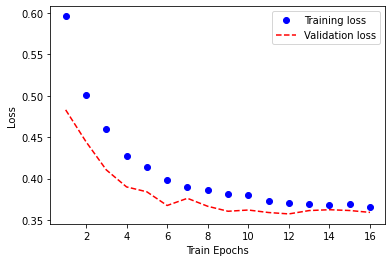

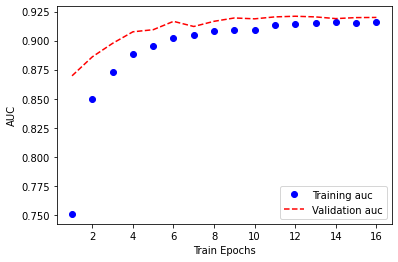

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

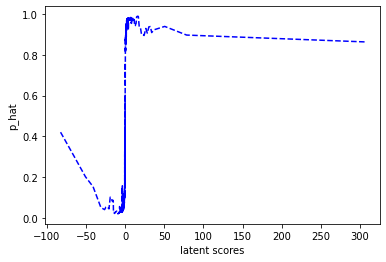

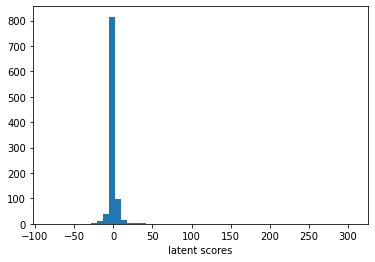

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

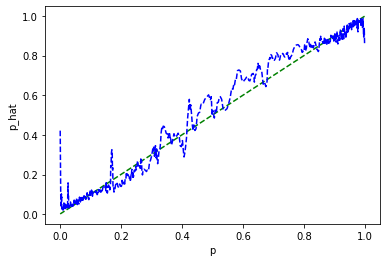

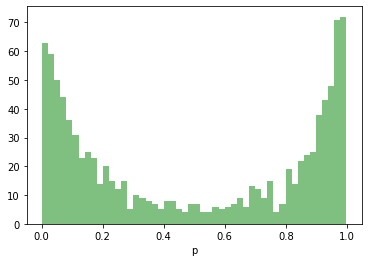

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

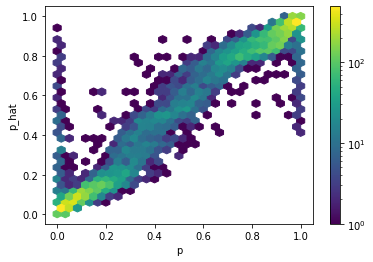

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

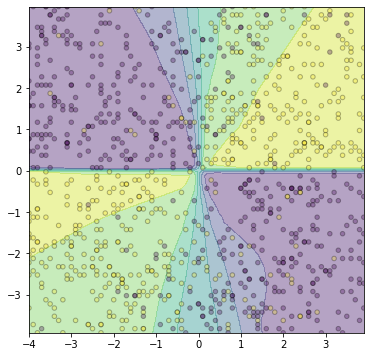

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.3576603829860687, 'epoch': 16},
 'best_auc': {'auc': 0.9207639694213867, 'epoch': 14},
 'best_accuracy': {'accuracy': 0.855650007724762, 'epoch': 12},
 'model': <keras.engine.sequential.Sequential at 0x7fe000418fd0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.447940468788147, 'epoch': 394},
  'best_auc': {'auc': 0.8846450448036194, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.8374500274658203, 'epoch': 392}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.41543206572532654, 'epoch': 394},
  'best_auc': {'auc': 0.8975673317909241, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.8469499945640564, 'epoch': 392}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.4104230999946594, 'epoch': 394},
  'best_auc': {'auc': 0.9029387831687927, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.8489999771118164, 'epoch': 394}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.4195099472999573, 'epoch': 828},
  'best_auc': {'auc': 0.8950267434120178, 'epoch': 828},
  

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25